<a href="https://colab.research.google.com/github/jceltruda/Projects-in-AI-and-ML/blob/main/ML_AI_Projects_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Dataset**

In [ ]:
!pip install kagglehub[pandas-datasets]

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from statsmodels.tools.tools import add_constant

# Load dataset
file_path = "Heart_Disease_Prediction.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "neurocipher/heartdisease",
  file_path,
)
print(df.head())

# VIF
features = df.drop(columns=['Heart Disease'], errors='ignore').select_dtypes(include=['number']) # Remove labels
vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i)
                   for i in range(len(features.columns))]

# Handle high correlation shown with VIF
vif_improvement = add_constant(features)

/tmp/ipython-input-1677231345.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'heartdisease' dataset.
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1              

**Task 1 - Implementation**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

# Create X, y for training
X = vif_improvement.values # Use features from VIF
if df['Heart Disease'].dtype == 'object':
    y = df['Heart Disease'].map({'Presence': 1, 'Absence': 0}).values # Convert labels to 0, 1
else:
    y = df['Heart Disease'].values


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=29, # Ensure reproducible results
    stratify=y       # Keeps class proportions the same
)

# Output header
print("Depth  | Train Acc  Train F1   | Test Acc   Test F1")
print("-------------------------------------------------------")

models = {} # Store trained models
best_f1 = float('-inf')
best_model_depth = None # Store best model

# Find best tree depth
for depth in range(2, 10):
  # Define model
  decision_tree = DecisionTreeClassifier(
      criterion='gini',    # Gini Index for splitting
      max_depth=depth,
      random_state=29      # Ensure reproducible results
  )

  # Fit model to data
  decision_tree.fit(X_train, y_train)

  # Save model
  models[depth] = decision_tree

  # Test model
  predictions_test = decision_tree.predict(X_test)
  predictions_train = decision_tree.predict(X_train)

  # Evaluate model
  f1_test = f1_score(y_test, predictions_test)
  f1_train = f1_score(y_train, predictions_train)
  accuracy_test = accuracy_score(y_test, predictions_test)
  accuracy_train = accuracy_score(y_train, predictions_train)
  print(f"{depth:<6} | {accuracy_train:.4f}     {f1_train:.4f}     | {accuracy_test:.4f}     {f1_test:.4f}")

  # Update best model
  if f1_test > best_f1:
    best_f1 = f1_test
    best_model_depth = depth

print(f"\nBest model: Depth = {best_model_depth}")

Depth  | Train Acc  Train F1   | Test Acc   Test F1
-------------------------------------------------------
2      | 0.7917     0.7273     | 0.7593     0.6667
3      | 0.8611     0.8315     | 0.8333     0.7907
4      | 0.8889     0.8621     | 0.8148     0.7619
5      | 0.9491     0.9405     | 0.8333     0.8085
6      | 0.9815     0.9789     | 0.7963     0.7660
7      | 1.0000     1.0000     | 0.7593     0.7451
8      | 1.0000     1.0000     | 0.7593     0.7451
9      | 1.0000     1.0000     | 0.7593     0.7451

Best model: Depth = 5


**Task 1 - Visualize Tree Structure**

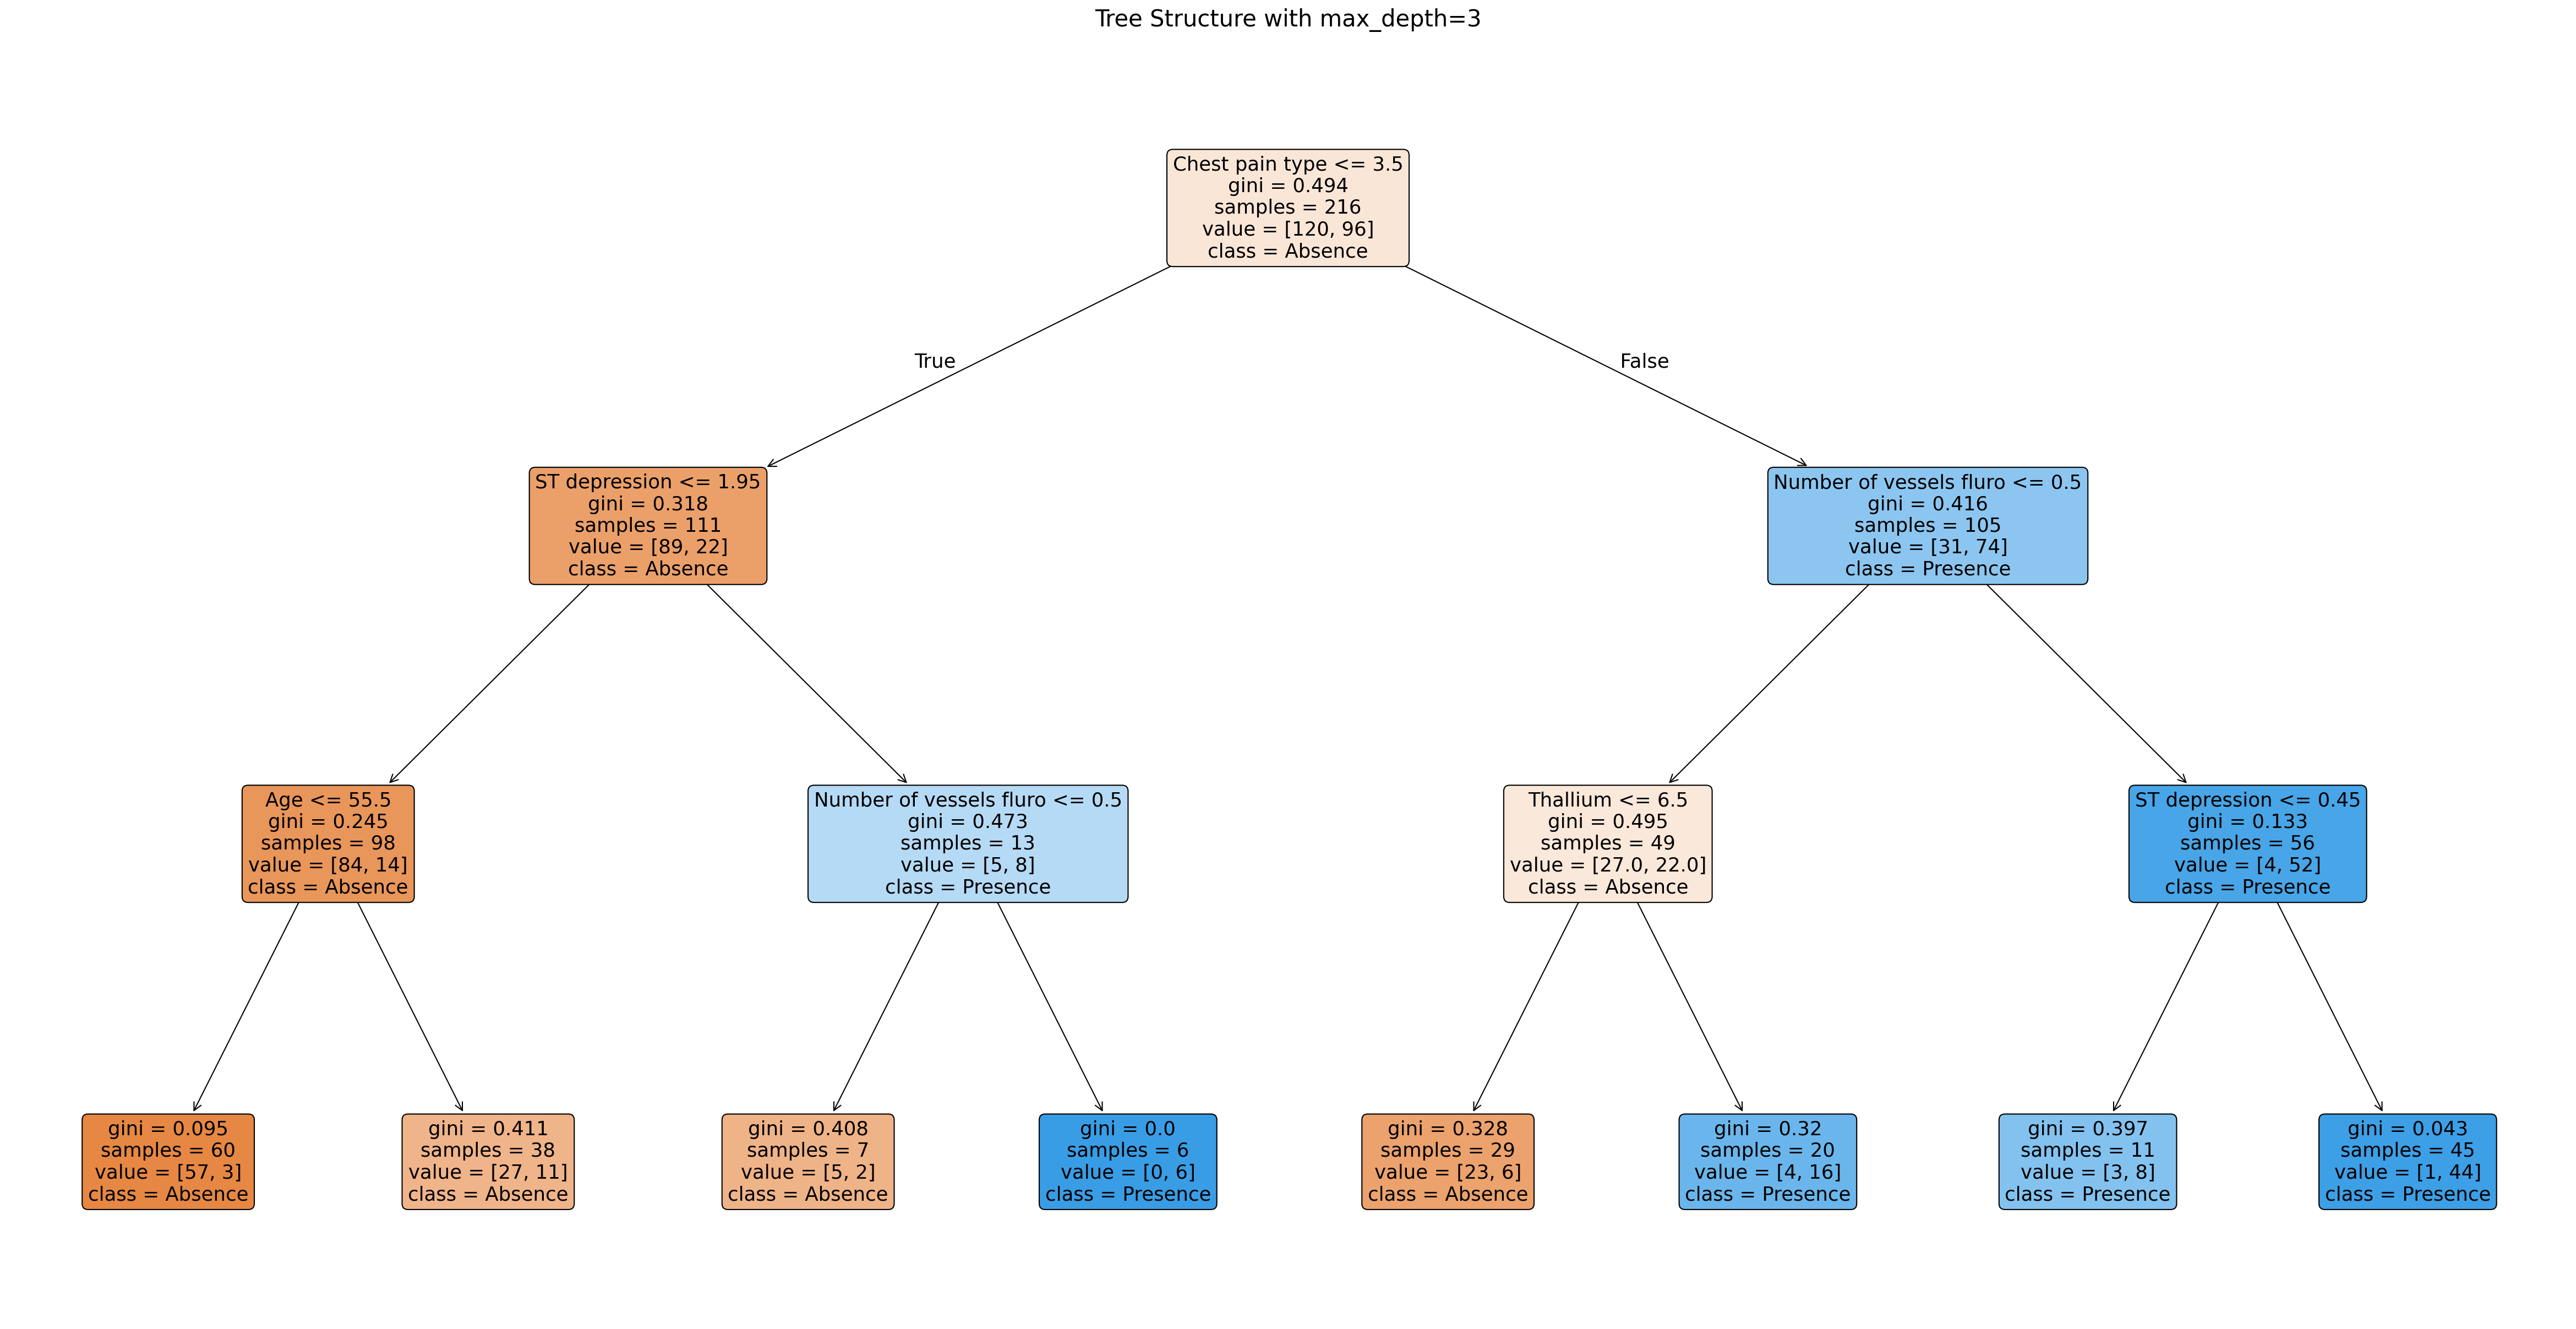

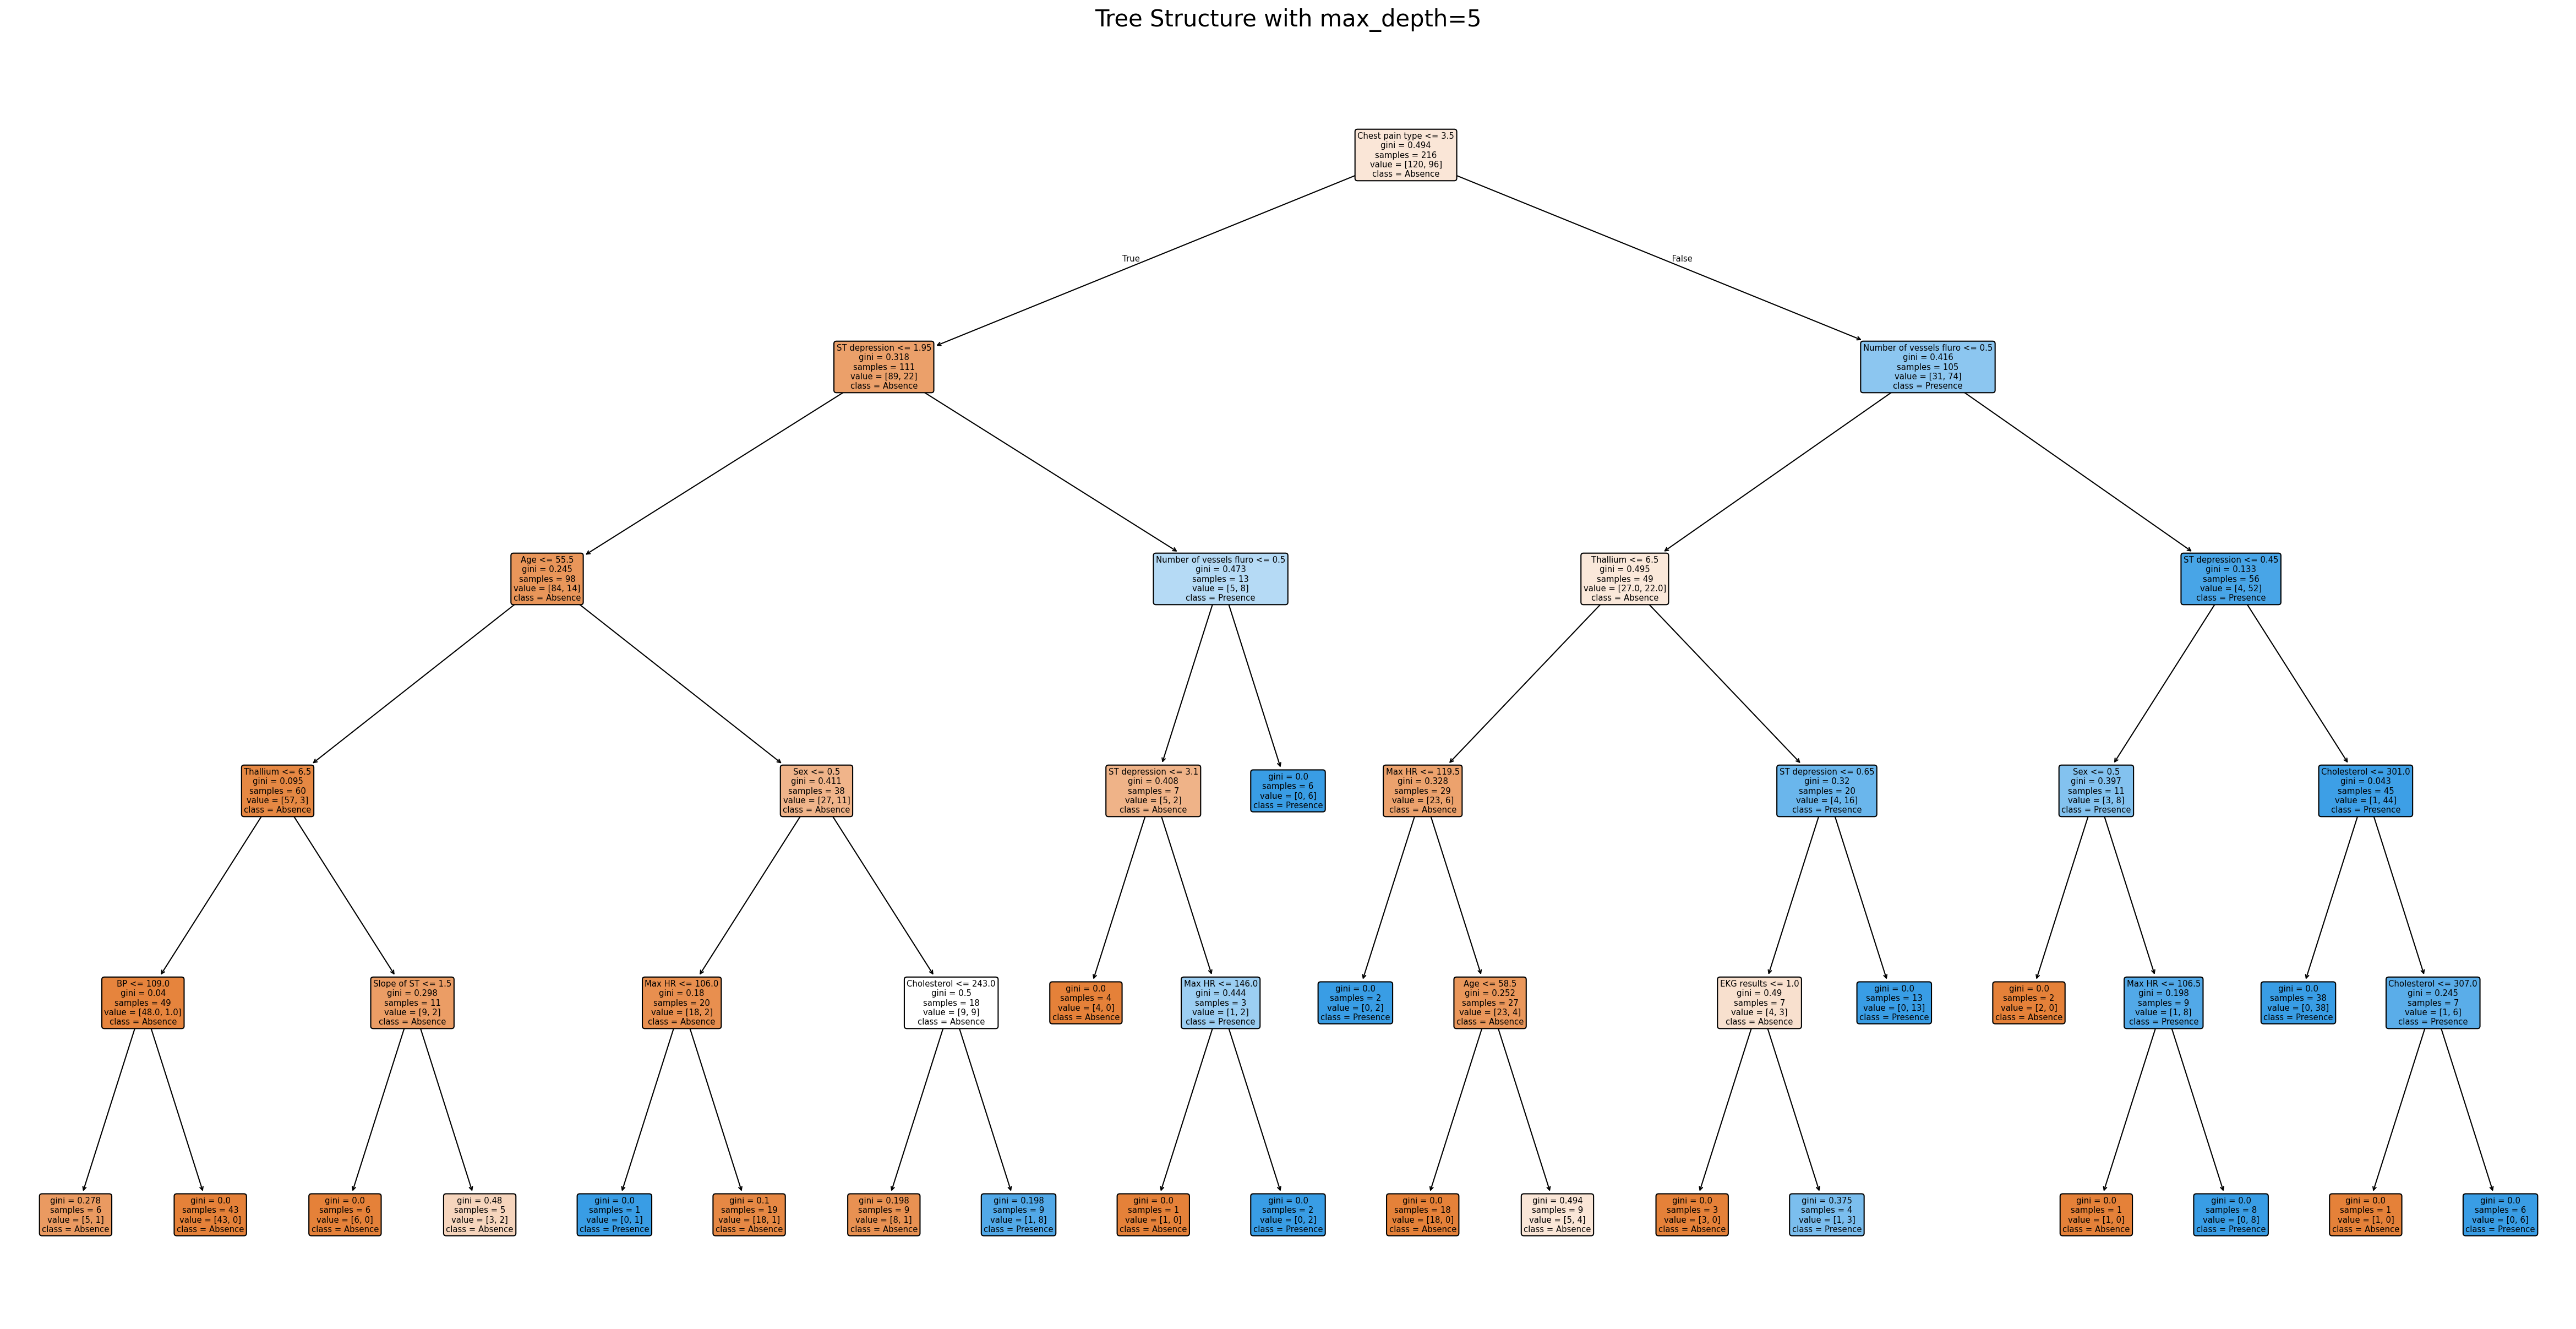

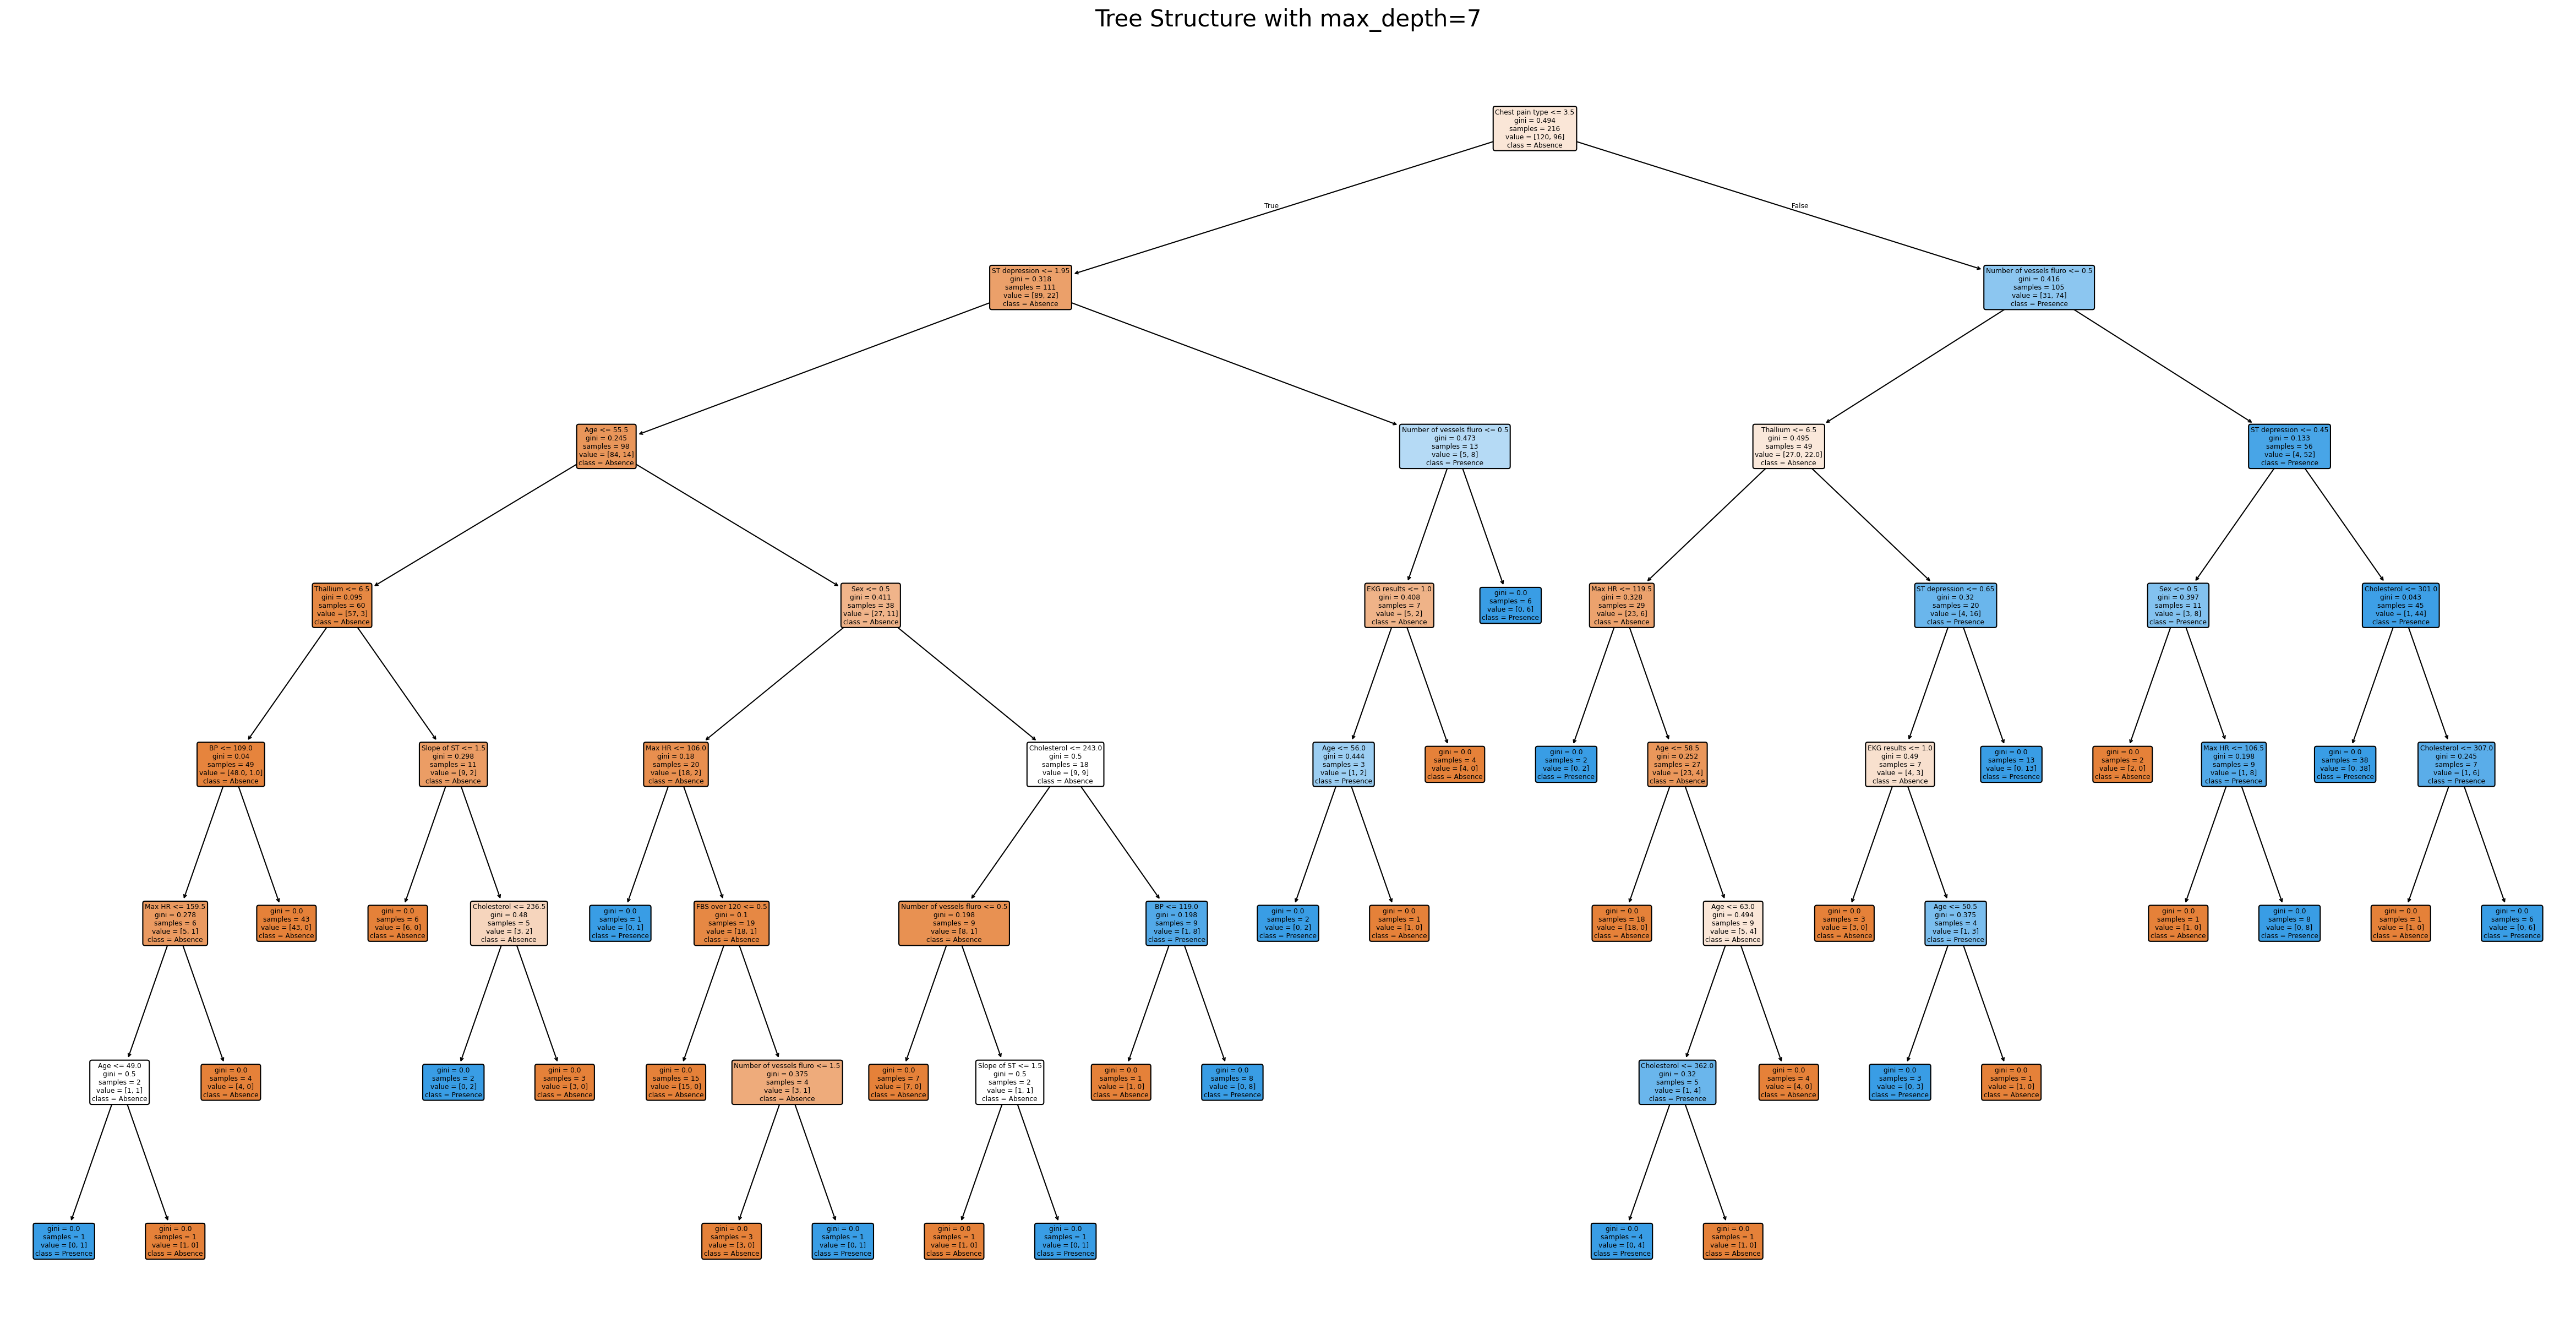

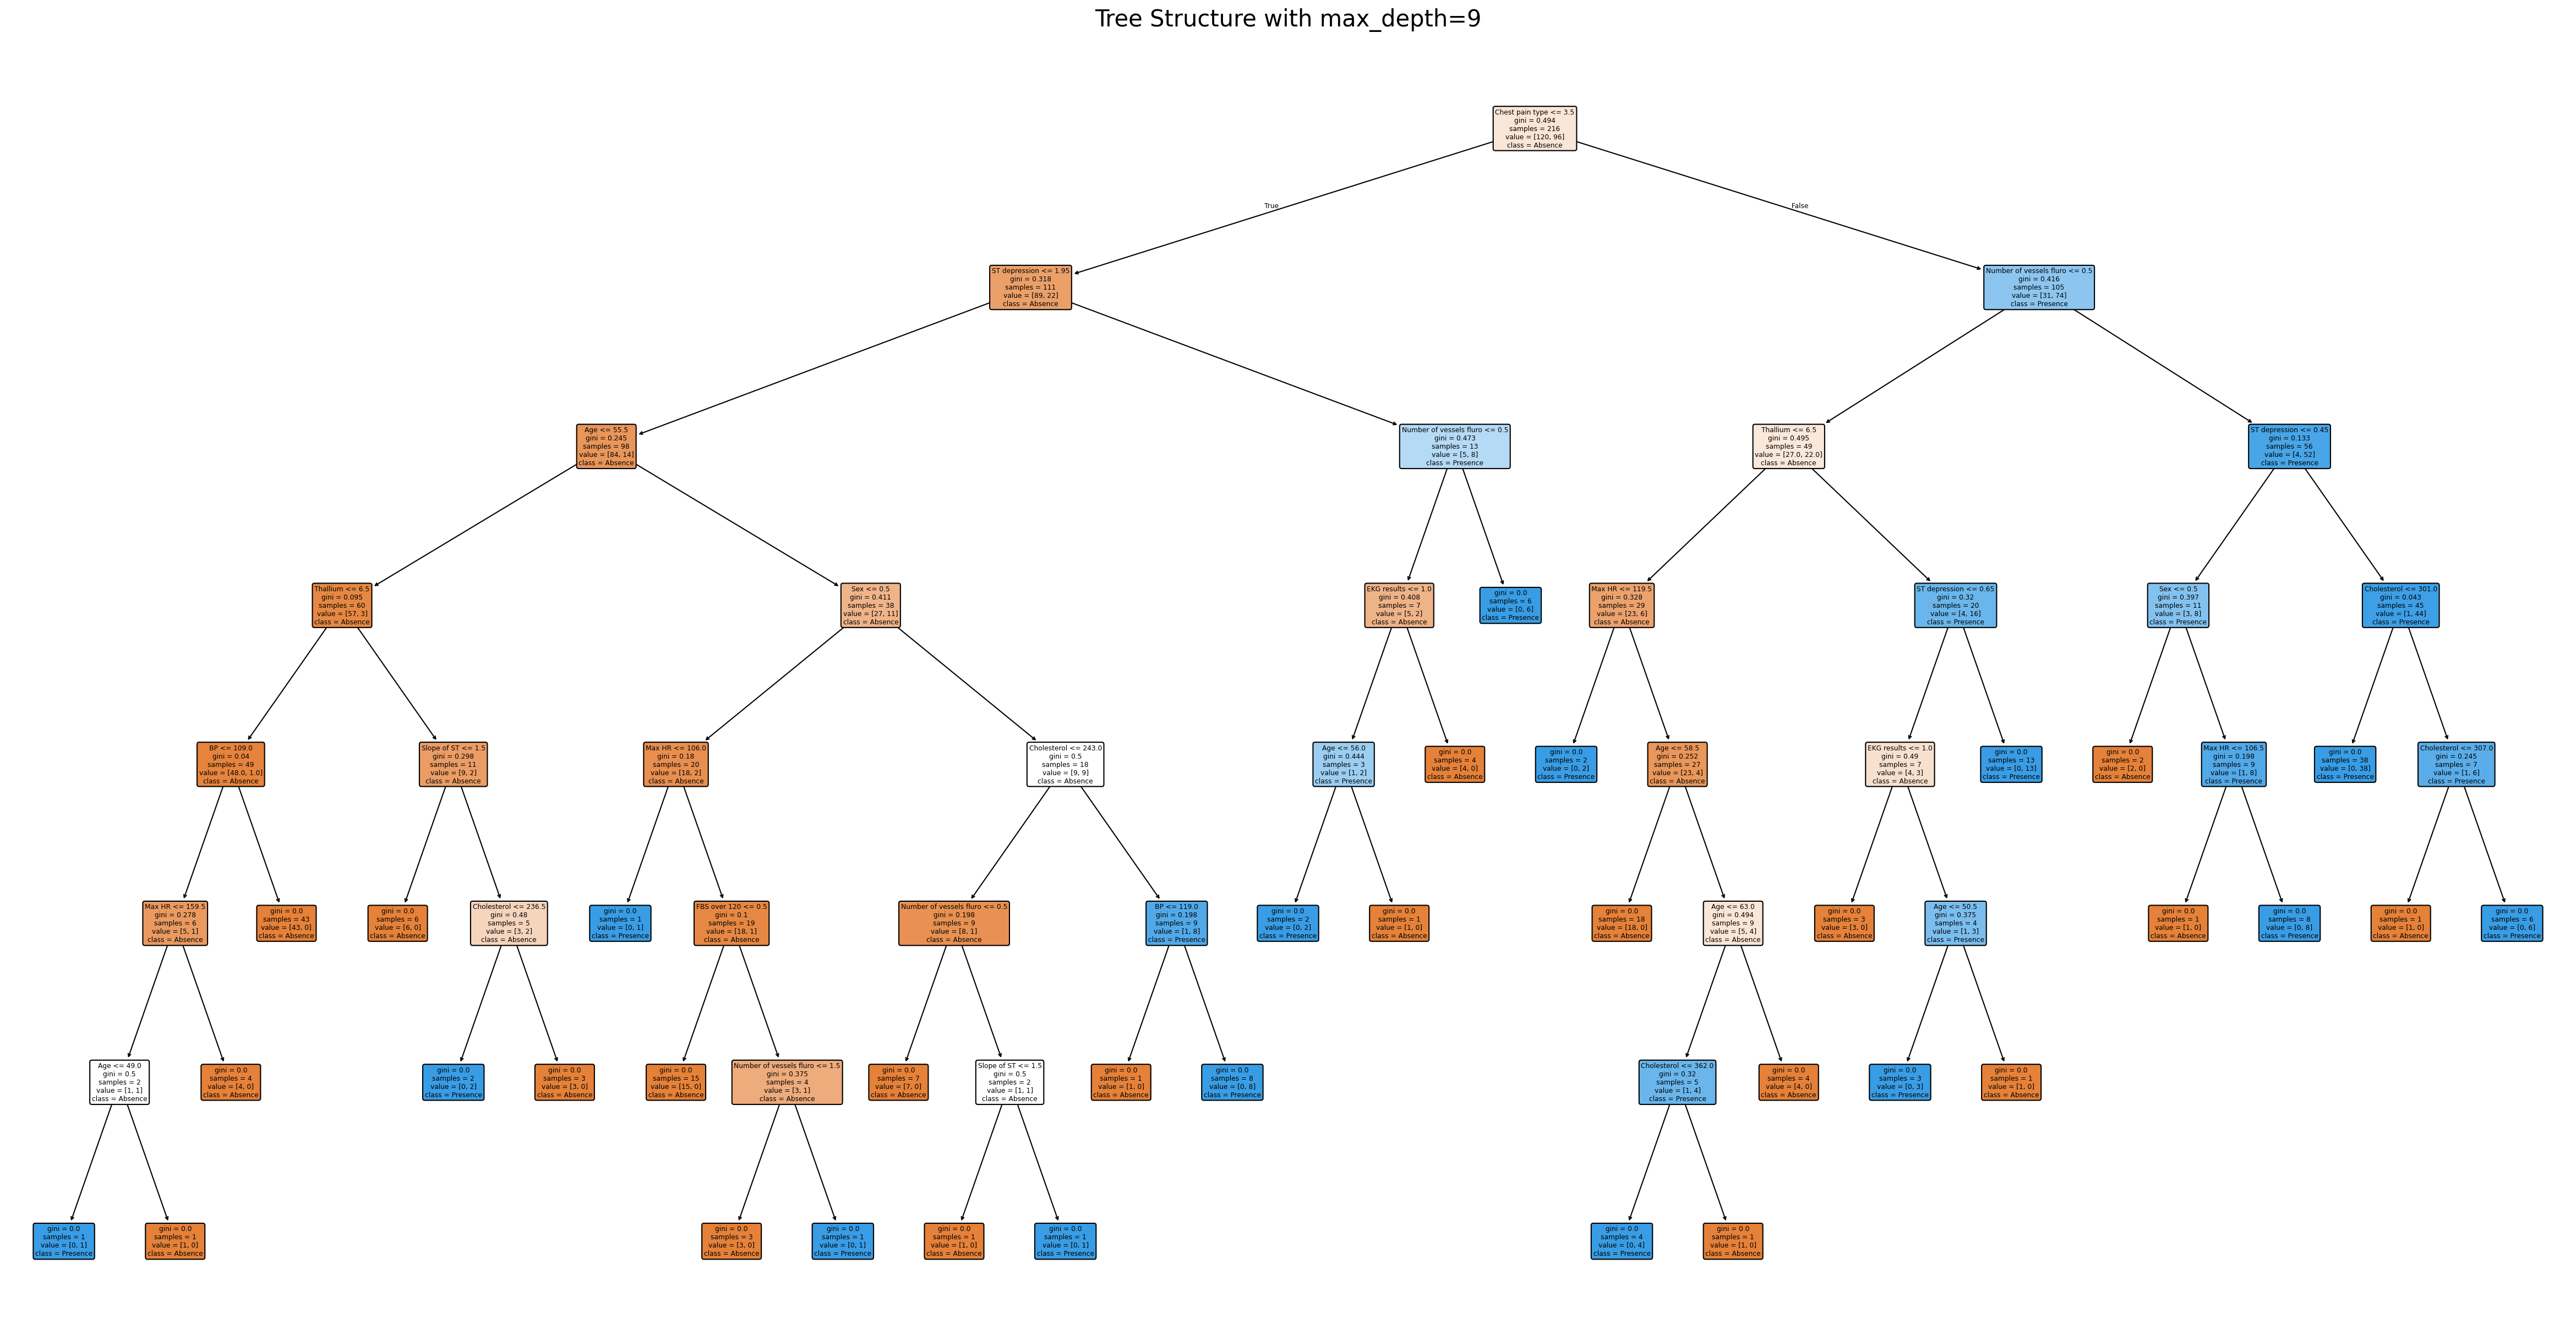

In [ ]:
from sklearn.tree import plot_tree

depths = [3, 5, 7, 9]

for depth in depths:

    visual_tree = models[depth]

    # Plot tree
    plt.figure(figsize=(40, 20), dpi=150)
    plot_tree(visual_tree,
              filled=True,
              feature_names=vif_improvement.columns,
              class_names=['Absence', 'Presence'],
              rounded=True)

    plt.title(f"Tree Structure with max_depth={depth}", fontsize=20, pad=20)
    plt.show()

As tree depth increases, the number of features and nodes increases exponentially. Chest pain type, Thallium, ST depression, and Number of vessels fluro appear near the root and at similar depths across all branches, meaning they are strong features for prediction. Performance falls after a depth of 5, where the number of pure nodes increases and overfitting begins (based on train vs. test f1 and accuracy, and pure node count). As the tree size grows it becomes increasingly uninterpretable with extremely specific decision rules, likely in an attempt to handle outliers in the training dataset. By depth = 7 the tree has completly fit the training data.

**Task 1 - Sensitivity Analysis**

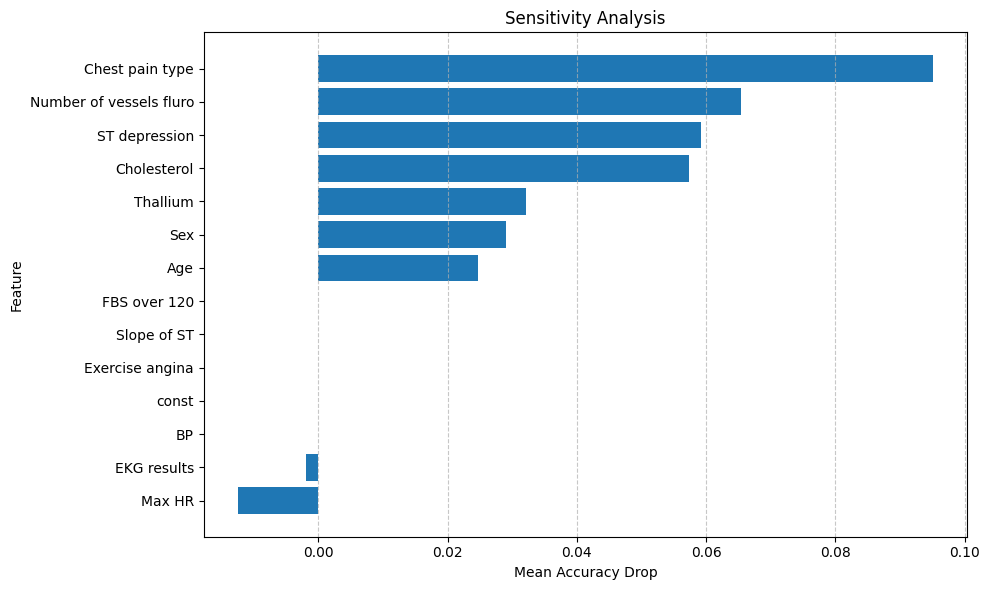

In [ ]:
from sklearn.inspection import permutation_importance

best_model = models[best_model_depth]

# Perform sensitivity analysis
result = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=30,
    random_state=29,
    n_jobs=-1
)
feature_names = vif_improvement.columns
importances = result.importances_mean

# Group data for printing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot results
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df['Feature'],
    importance_df['Importance'],
)

plt.title(f"Sensitivity Analysis")
plt.xlabel("Mean Accuracy Drop")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Sensitivity analysis is a method to determine how sensitive a model's output is to changes in the input features. A model is sensitive if a small change in a feature drastically changes the output. It also helps to demonstrate which features are most closely linked with the output. It is calculated by transforming feature i in a dataset, making predictions on the transformed  and regular data, and subtracting the transformed score from the standard score.

The sensitivity analysis indicates that the model is highly sensitive to changes in Number of vessels fluro, Thallium, Cholesterol, ST depression, and Chest pain type. These features appear higher in the decision tree, and altering these values redirects model output to entirely different branches. Variables that appear in very few nodes show low sensitivy, and don't drastically impact model output.

Resource:
* https://medium.com/@einat_93627/understand-your-black-box-model-using-sensitivity-analysis-practical-guide-ef6ac4175e55

**Task 2**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# Stratified K-Fold Cross Validation
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)

# Original tree
dt_results = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=k_fold,
    scoring=['accuracy', 'precision', 'f1']
)

# Output Average Scores
print("Original Tree Results:")
print(f"Mean Accuracy:  {dt_results['test_accuracy'].mean():.4f}")
print(f"Mean Precision: {dt_results['test_precision'].mean():.4f}")
print(f"Mean F1 Score:  {dt_results['test_f1'].mean():.4f}\n")


# Random Forest
random_forest = RandomForestClassifier(random_state=29)

# Random Forest Cross-Validation
rf_results = cross_validate(
    random_forest,
    X_train,
    y_train,
    cv=k_fold,
    scoring=['accuracy', 'precision', 'f1']
)

# Output Average Scores
print("Random Forest Results:")
print(f"Mean Accuracy:  {rf_results['test_accuracy'].mean():.4f}")
print(f"Mean Precision: {rf_results['test_precision'].mean():.4f}")
print(f"Mean F1 Score:  {rf_results['test_f1'].mean():.4f}\n")


# XGBoost
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=29
)

# XGBoost Cross-Validation
xgb_results = cross_validate(
    xgb_model,
    X_train,
    y_train,
    cv=k_fold,
    scoring=['accuracy', 'precision', 'f1']
)

# Output Average Scores
print("XGBoost Results:")
print(f"Mean Accuracy:  {xgb_results['test_accuracy'].mean():.4f}")
print(f"Mean Precision: {xgb_results['test_precision'].mean():.4f}")
print(f"Mean F1 Score:  {xgb_results['test_f1'].mean():.4f}")

Original Tree Results:
Mean Accuracy:  0.7871
Mean Precision: 0.7887
Mean F1 Score:  0.7429

Random Forest Results:
Mean Accuracy:  0.8382
Mean Precision: 0.8660
Mean F1 Score:  0.8046

XGBoost Results:
Mean Accuracy:  0.8057
Mean Precision: 0.8184
Mean F1 Score:  0.7613


These algorithms produce different results, with Random Forest significantly outperforming XGBoost on this task. It performs better across all 3 metrics, marking a large performance improvement on both the original decision tree and XGBoost.

XGBoost has lower metrics then Random Forest, but is still an improvement upon the original decision tree. The three metrics do not produce different rankings, there is a clear hierarchy in model performance.

**Task 3 - Implementation**

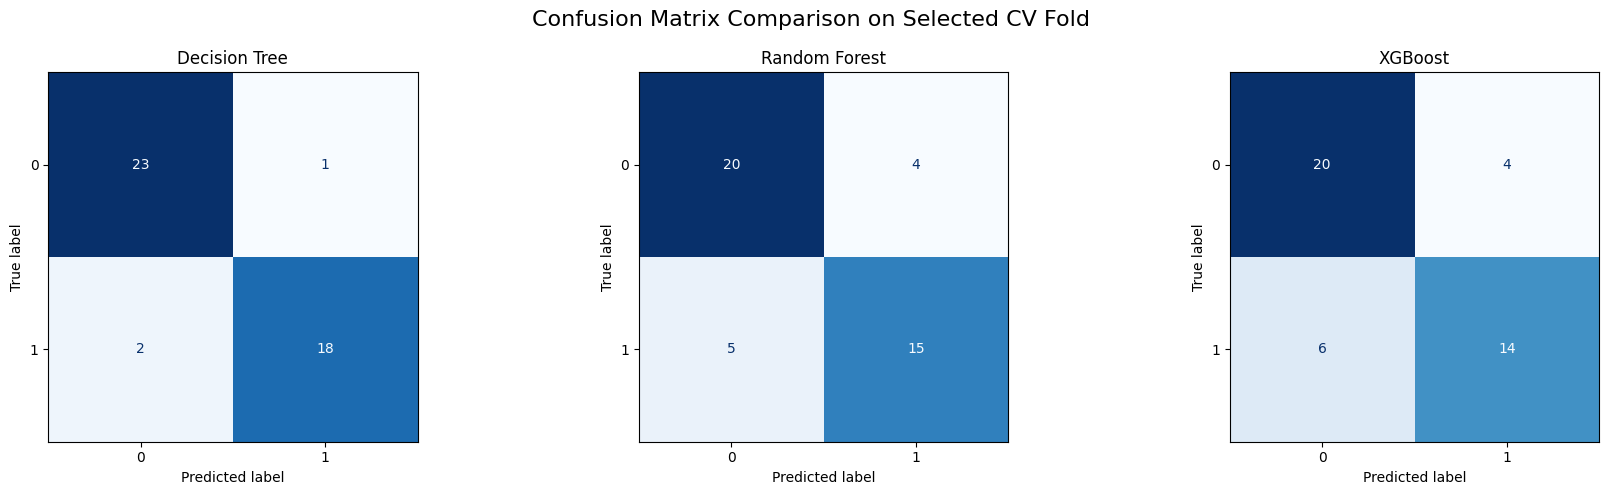

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

# Confusion Matrix

# Take data from one test fold
train_idx, val_idx = next(k_fold.split(X_train, y_train))
X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

# Train on fold
random_forest.fit(X_fold_train, y_fold_train)
xgb_model.fit(X_fold_train, y_fold_train)

# Create plot
def plot_confusion_matrix(model, name, X_val, y_val, ax):
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_val,
        y_val,
        cmap='Blues',
        ax=ax,
        colorbar=False
    )
    ax.set_title(name)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_confusion_matrix(best_model, "Decision Tree", X_fold_val, y_fold_val, axes[0])
plot_confusion_matrix(random_forest, "Random Forest", X_fold_val, y_fold_val, axes[1])
plot_confusion_matrix(xgb_model, "XGBoost", X_fold_val, y_fold_val, axes[2])

plt.suptitle("Confusion Matrix Comparison on Selected CV Fold", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# T-test

# Compare DT vs Random Forest
t_stat, p_val = stats.ttest_rel(dt_results['test_accuracy'], rf_results['test_accuracy'])
print(f"Decision Tree vs Random Forest: P-value = {p_val:.4f}\n")

# Compare DT vs XGBoost
t_stat, p_val = stats.ttest_rel(dt_results['test_accuracy'], xgb_results['test_accuracy'])
print(f"Decision Tree vs XGBoost: P-value = {p_val:.4f}\n")

# Compare Random Forest vs XGBoost
t_stat, p_val = stats.ttest_rel(rf_results['test_accuracy'], xgb_results['test_accuracy'])
print(f"Random Forest vs XGBoost: P-value = {p_val:.4f}\n")


Decision Tree vs Random Forest: P-value = 0.0520

Decision Tree vs XGBoost: P-value = 0.4557

Random Forest vs XGBoost: P-value = 0.2070



**Task 3 - Discussion**

**Statistical Test:**

After further examining the models, there is no significant difference between them, I cannot confidently say any model is better than another. The confusion matrix showed nearly identical confusion across all 3 models, and the t-test supported this idea as well with all p values > 0.05. The Decision Tree vs Random Forest comparison was close to this value, indicating the Random Forest is approaching significance.

**Bias vs. Variance:**

Random Forests use multiple decision trees which vote on the final prediction. This practice helps reduce variance by making it difficult to overfit and memorize the training data. This potentially makes it more difficult to learn from complex data, which may lead to slightly higher bias than other trees.

XGBoost builds trees sequentially by fixing the mistakes of previous trees. This helps raise training accuracy and lower bias, but has potential to overfit on the data and give the model high variance without regularization.

The depth of the standard decision tree related to its bias and variance. The tree's with high depth overfit on the data and had high variance when used with new data, while shallow trees were too general and didn't capture all relationships in the data, giving them high bias.

**Graduate Task**


In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Initialize XGBoost
xgb_search = XGBClassifier(
    eval_metric='logloss',
    random_state=29
)

# Grid search
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 5, 6, 7],
    'subsample': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_search,
    param_grid=params,
    scoring=['accuracy', 'f1'],
    refit='accuracy',
    cv=k_fold,
    n_jobs=-1, # Use all available cpus
)

grid_search.fit(X_train, y_train) # Perform grid search

# Output results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'subsample': 0.8}
Best Accuracy: 0.8568


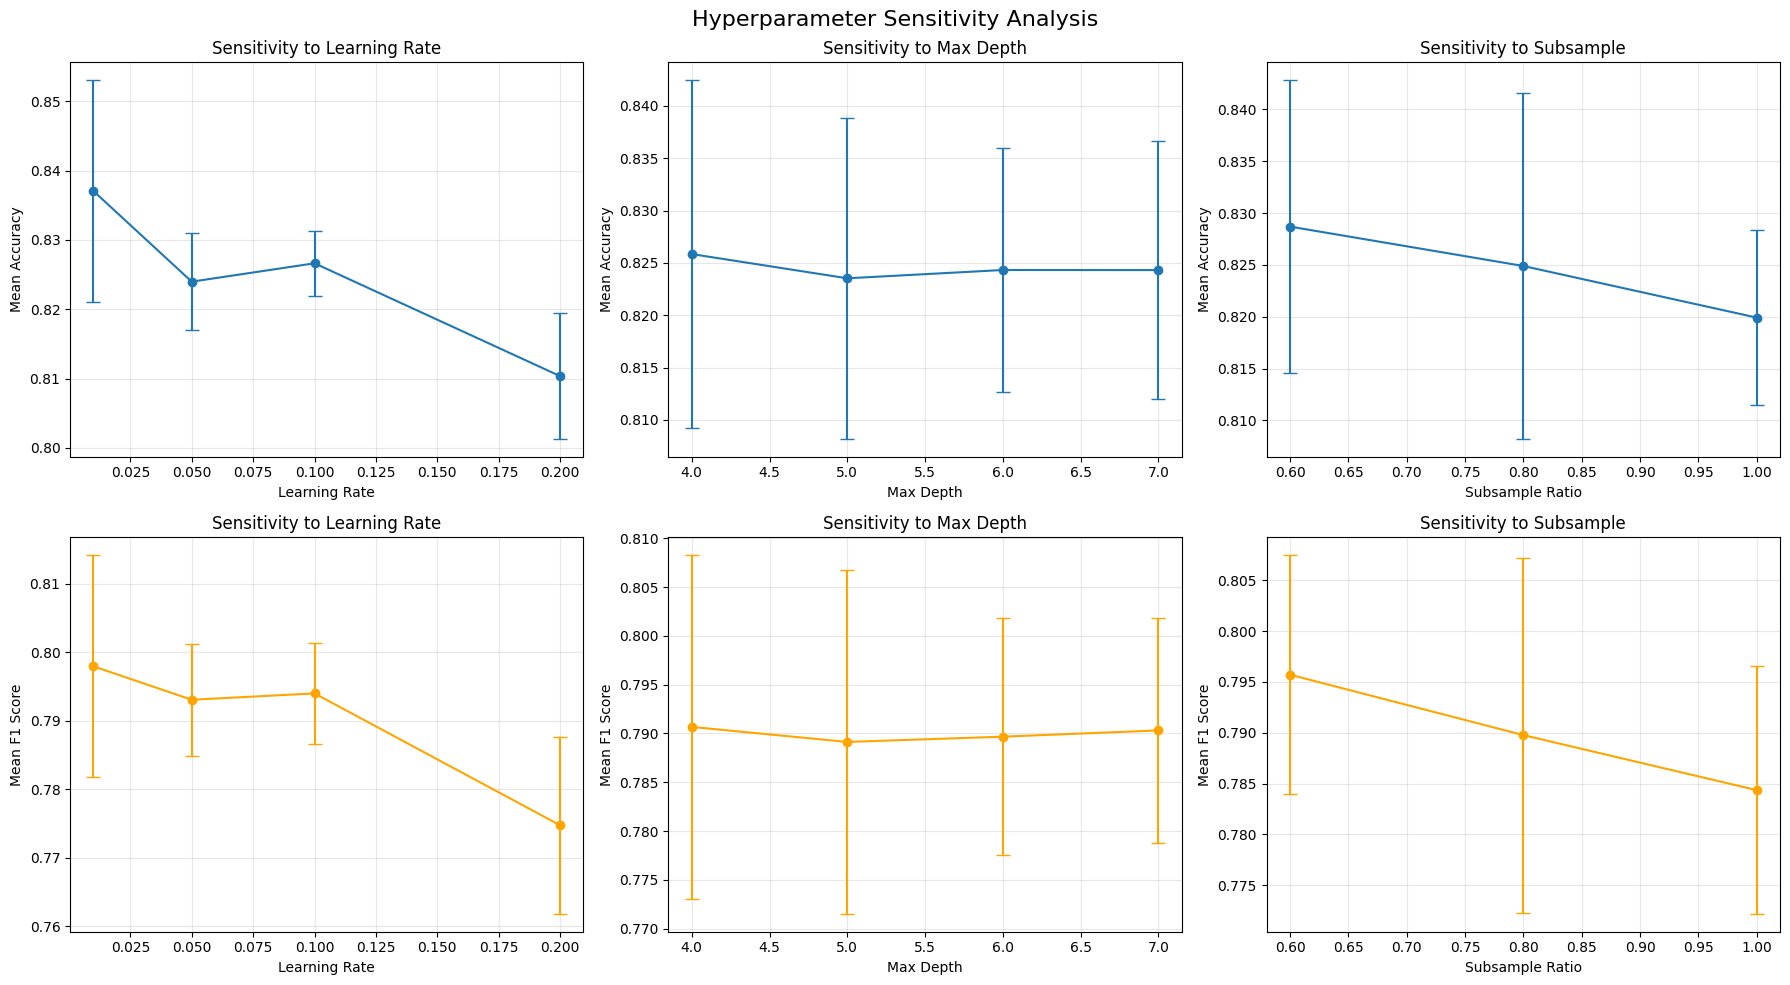

In [ ]:
# Sensitivity analysis

results = pd.DataFrame(grid_search.cv_results_)

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Learning rate accuracy sensitivity
lr_acc = results.groupby('param_learning_rate')['mean_test_accuracy'].agg(['mean', 'std'])
axes[0,0].errorbar(lr_acc.index, lr_acc['mean'], yerr=lr_acc['std'], marker='o', capsize=5)
axes[0,0].set_xlabel('Learning Rate')
axes[0,0].set_ylabel('Mean Accuracy')
axes[0,0].set_title('Sensitivity to Learning Rate')
axes[0,0].grid(True, alpha=0.3)

# Max depth sensitivity
depth_acc = results.groupby('param_max_depth')['mean_test_accuracy'].agg(['mean', 'std'])
axes[0,1].errorbar(depth_acc.index, depth_acc['mean'], yerr=depth_acc['std'], marker='o', capsize=5)
axes[0,1].set_xlabel('Max Depth')
axes[0,1].set_ylabel('Mean Accuracy')
axes[0,1].set_title('Sensitivity to Max Depth')
axes[0,1].grid(True, alpha=0.3)

# Subsample sensitivity
subsample_acc = results.groupby('param_subsample')['mean_test_accuracy'].agg(['mean', 'std'])
axes[0,2].errorbar(subsample_acc.index, subsample_acc['mean'], yerr=subsample_acc['std'], marker='o', capsize=5)
axes[0,2].set_xlabel('Subsample Ratio')
axes[0,2].set_ylabel('Mean Accuracy')
axes[0,2].set_title('Sensitivity to Subsample')
axes[0,2].grid(True, alpha=0.3)

# Learning rate F1 sensitivity
lr_f1 = results.groupby('param_learning_rate')['mean_test_f1'].agg(['mean', 'std'])
axes[1,0].errorbar(lr_f1.index, lr_f1['mean'], yerr=lr_f1['std'], marker='o', capsize=5, color='orange')
axes[1,0].set_xlabel('Learning Rate')
axes[1,0].set_ylabel('Mean F1 Score')
axes[1,0].set_title('Sensitivity to Learning Rate')
axes[1,0].grid(True, alpha=0.3)

# Max depth F1 sensitivity
depth_f1 = results.groupby('param_max_depth')['mean_test_f1'].agg(['mean', 'std'])
axes[1,1].errorbar(depth_f1.index, depth_f1['mean'], yerr=depth_f1['std'], marker='o', capsize=5, color='orange')
axes[1,1].set_xlabel('Max Depth')
axes[1,1].set_ylabel('Mean F1 Score')
axes[1,1].set_title('Sensitivity to Max Depth')
axes[1,1].grid(True, alpha=0.3)

# Subsample F1 sensitivity
subsample_f1 = results.groupby('param_subsample')['mean_test_f1'].agg(['mean', 'std'])
axes[1,2].errorbar(subsample_f1.index, subsample_f1['mean'], yerr=subsample_f1['std'], marker='o', capsize=5, color='orange')
axes[1,2].set_xlabel('Subsample Ratio')
axes[1,2].set_ylabel('Mean F1 Score')
axes[1,2].set_title('Sensitivity to Subsample')
axes[1,2].grid(True, alpha=0.3)

plt.suptitle('Hyperparameter Sensitivity Analysis', fontsize=16)
plt.tight_layout()
plt.show()

The sensitivity analysis revealed that the model is most sensitive to variations in the learning rate, while it is not very sensitive to the max depth parameter. Increased learning rates yielded worse accuracy and F1 score, indicating weight adjustments were too large to allow the model to find the minimum loss. Increasing the subsample parameter also lead to lower accuracy and f1 score, meaning training on a larger portion of the dataset may have allowed the model to overfit and not be able to generalize as well.